已保存：results/summary_missing.csv


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10924\2890009365.py:92: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(agg_ms).reset_index()


,method,N,RMSE,EndErr,Jerk,Trainms,Inferms
0,KMP,96.0,0.907 ± 0.434,0.575 ± 0.312,37860.605 ± 12914.634,0.884 ± 0.457,1.254 ± 3.682
1,ProMP,96.0,0.783 ± 0.452,0.743 ± 0.544,32630.790 ± 11715.980,1.990 ± 0.424,1.568 ± 3.721
2,U-KMP,96.0,1.304 ± 0.778,0.575 ± 0.312,45669.243 ± 17437.227,0.884 ± 0.457,1.107 ± 3.630


已保存：results/summary_obstacle.csv


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10924\2890009365.py:92: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(agg_ms).reset_index()


,method,N,RMSE,EndErr,Jerk,Trainms,Inferms
0,KMP,48.0,1.602 ± 0.539,1.246 ± 1.462,23943.616 ± 6967.573,,
1,U-KMP,48.0,1.602 ± 0.539,1.246 ± 1.462,23943.820 ± 6967.527,,


已保存：results/summary_reproduction.csv


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10924\2890009365.py:92: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(agg_ms).reset_index()


,method,N,RMSE,EndErr,Jerk,Trainms,Inferms
0,DMP,192.0,7924212656678737397513713614848.000 ± 90745863...,14942038680271471105579774115840.000 ± 1481272...,14683.607 ± 15729.797,1.019 ± 1.503,3.685 ± 3.789
1,GP,48.0,1.215 ± 0.627,0.575 ± 0.314,22442.444 ± 7492.333,0.009 ± 0.005,737.553 ± 220.903
2,KMP,96.0,1.215 ± 0.624,0.575 ± 0.312,22153.010 ± 7337.120,0.264 ± 0.193,3.162 ± 1.164
3,ProMP,48.0,1.216 ± 0.625,0.579 ± 0.320,19625.164 ± 7251.281,3.049 ± 2.225,0.033 ± 0.026
4,U-KMP,96.0,1.215 ± 0.624,0.575 ± 0.312,22169.547 ± 7338.068,0.264 ± 0.193,3.072 ± 0.766


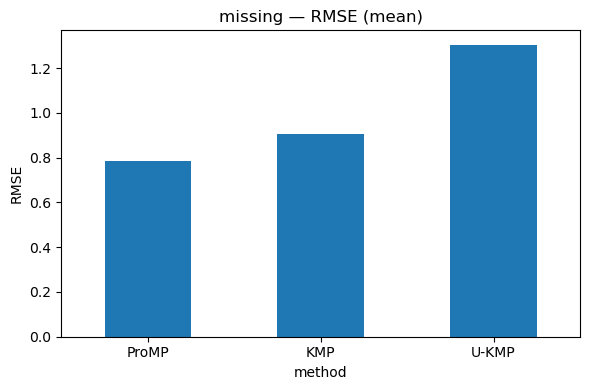

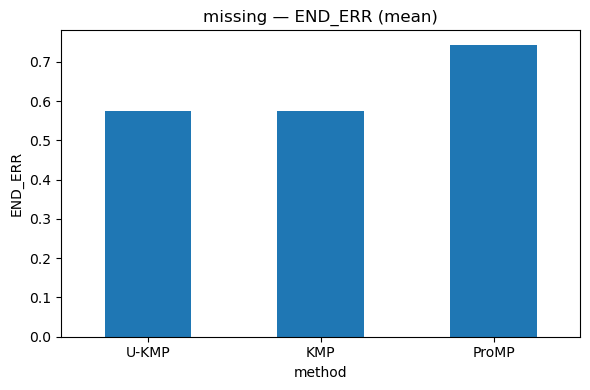

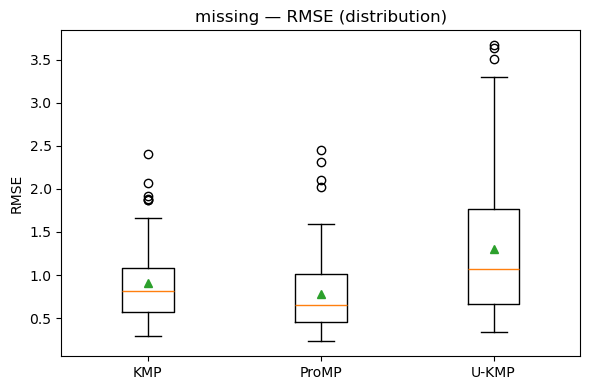

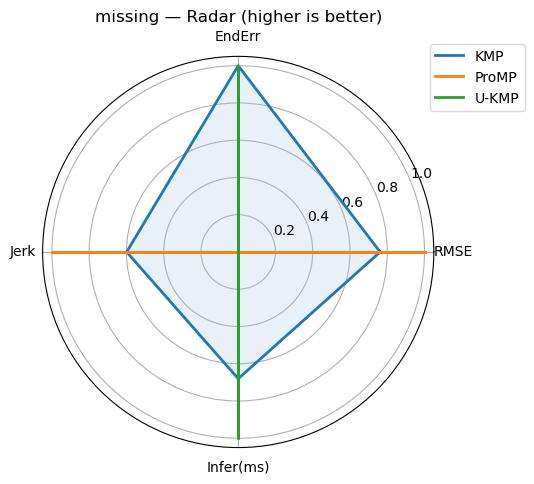

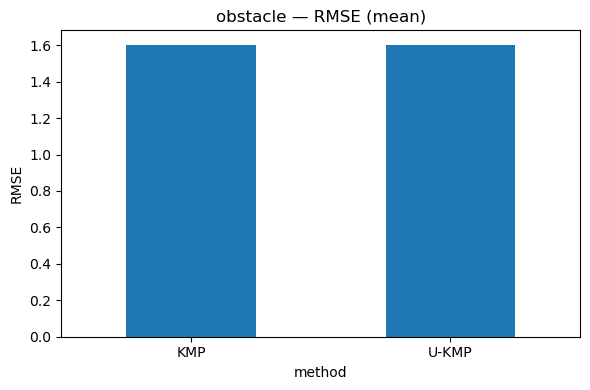

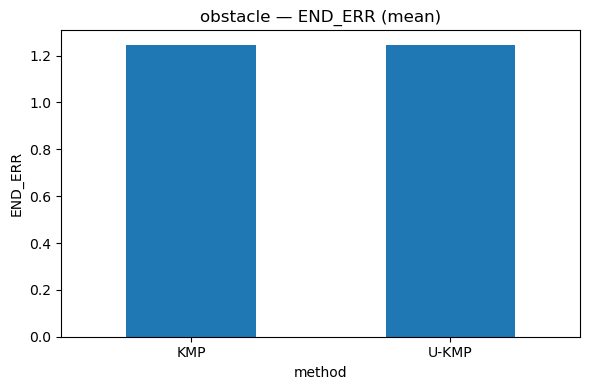

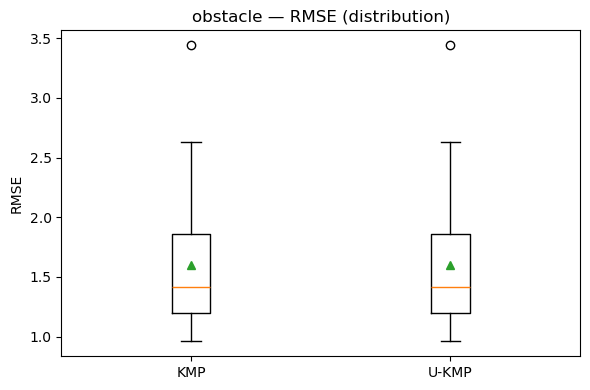

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10924\2890009365.py:153: RuntimeWarning: All-NaN slice encountered
  lo, hi = np.nanmin(v), np.nanmax(v)


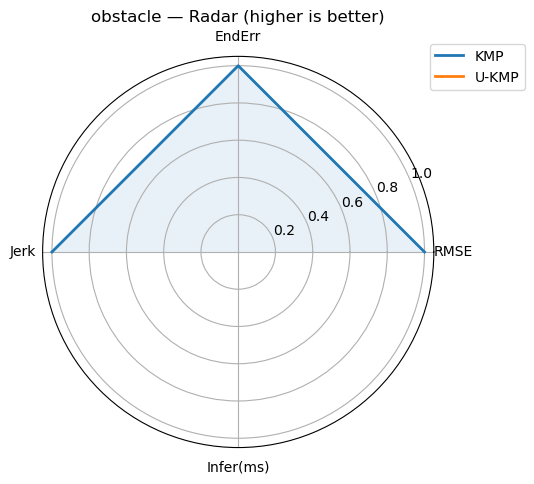

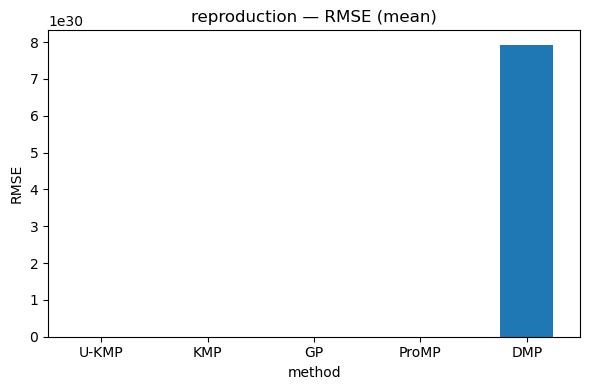

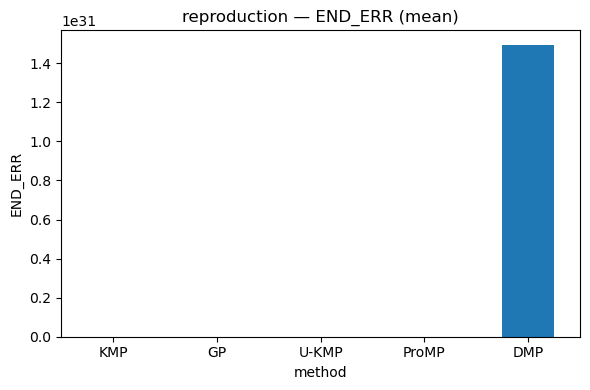

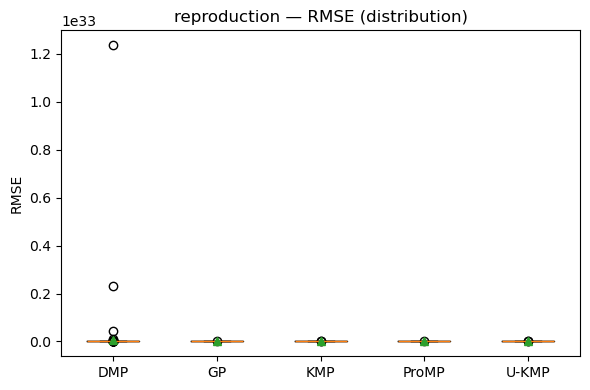

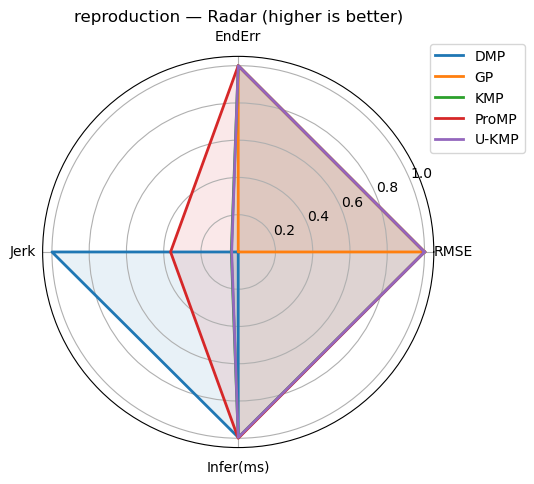

完成：已在 results/ 产出 summary_*.csv，在 figs/ 产出 bar_*.png / box_*.png / radar_*.png


In [5]:
# results_summary.ipynb 统一汇总 & 画图
import os, glob, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs('results', exist_ok=True)
os.makedirs('figs', exist_ok=True)

# -------- 1) 读取与标准化 --------
def guess_experiment(fname: str):
    f = os.path.basename(fname).lower()
    if 'missing' in f:
        return 'missing'
    if 'obstacle' in f:
        return 'obstacle'
    # 默认都归到 reproduction（包括 reproduction_LOO_*）
    return 'reproduction'

def std_columns(df: pd.DataFrame):
    # 列名全部小写，去空格
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]

    # 允许一些别名 -> 标准名
    alias = {
        'end': 'end_err',
        'end_error': 'end_err',
        'endpoint': 'end_err',
        'endpoint_err': 'end_err',
        'train': 'train_ms',
        'infer': 'infer_ms',
        'time_train': 'train_ms',
        'time_infer': 'infer_ms',
    }
    for a, b in alias.items():
        if a in df.columns and b not in df.columns:
            df.rename(columns={a: b}, inplace=True)

    # 必要列尝试补齐
    if 'method' not in df.columns and 'algo' in df.columns:
        df.rename(columns={'algo':'method'}, inplace=True)

    # 统一保留的列
    keep = ['method','letter','fold','rmse','end_err','jerk','train_ms','infer_ms']
    for k in keep:
        if k not in df.columns:
            df[k] = np.nan
    return df[keep]

all_rows = []
csv_files = sorted(glob.glob('results/*.csv'))
if not csv_files:
    raise FileNotFoundError("没有在 ./results 下找到任何 CSV。请先运行各方法的实验以生成 CSV。")

for f in csv_files:
    try:
        t = pd.read_csv(f)
    except Exception:
        # 有些 CSV 可能没有表头，这里尝试用固定表头读取
        hdr = ['method','letter','fold','rmse','end_err','jerk','train_ms','infer_ms']
        t = pd.read_csv(f, header=None, names=hdr)
    t = std_columns(t)
    t['experiment'] = guess_experiment(f)
    # 方法名做个规范（大写首字母）
    t['method'] = t['method'].astype(str).str.strip()
    t['method'] = t['method'].str.upper().replace({
        'PROMP':'ProMP','DMP':'DMP',
        'KMP':'KMP','U-KMP':'U-KMP','UKMP':'U-KMP',
        'GP':'GP','GPR':'GP'
    })
    all_rows.append(t)

data = pd.concat(all_rows, ignore_index=True)
# 丢掉明显非法数
for col in ['rmse','end_err','jerk','train_ms','infer_ms']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['rmse'])

# -------- 2) 每个实验分别汇总：均值 ± 标准差 --------
def mean_std_table(df: pd.DataFrame):
    g = df.groupby('method', dropna=False)
    def agg_ms(x):
        return pd.Series({
            'RMSE_mean': x['rmse'].mean(),     'RMSE_std': x['rmse'].std(),
            'End_mean':  x['end_err'].mean(),  'End_std':  x['end_err'].std(),
            'Jerk_mean': x['jerk'].mean(),     'Jerk_std': x['jerk'].std(),
            'Train_ms_mean': x['train_ms'].mean(), 'Train_ms_std': x['train_ms'].std(),
            'Infer_ms_mean': x['infer_ms'].mean(), 'Infer_ms_std': x['infer_ms'].std(),
            'N': len(x)
        })
    out = g.apply(agg_ms).reset_index()
    # 生成 “均值 ± 标准差” 展示列
    def pm(m, s): 
        if pd.isna(m): return ''
        if pd.isna(s) or s==0: return f'{m:.3f}'
        return f'{m:.3f} ± {s:.3f}'
    out['RMSE']    = [pm(m,s) for m,s in zip(out['RMSE_mean'], out['RMSE_std'])]
    out['EndErr']  = [pm(m,s) for m,s in zip(out['End_mean'],  out['End_std'])]
    out['Jerk']    = [pm(m,s) for m,s in zip(out['Jerk_mean'], out['Jerk_std'])]
    out['Trainms'] = [pm(m,s) for m,s in zip(out['Train_ms_mean'], out['Train_ms_std'])]
    out['Inferms'] = [pm(m,s) for m,s in zip(out['Infer_ms_mean'], out['Infer_ms_std'])]
    pretty = out[['method','N','RMSE','EndErr','Jerk','Trainms','Inferms']].sort_values('method')
    return out, pretty

experiments = sorted(data['experiment'].unique())
summary_dict = {}

for exp in experiments:
    df_e = data[data['experiment']==exp]
    raw, pretty = mean_std_table(df_e)
    summary_dict[exp] = (raw, pretty)
    pretty.to_csv(f'results/summary_{exp}.csv', index=False)
    print(f'已保存：results/summary_{exp}.csv')
    display(pretty)

# -------- 3) 画图（柱状图、箱线图、雷达图） --------
def bar_compare(exp, metric='rmse'):
    df_e = data[data['experiment']==exp]
    g = df_e.groupby('method')[metric].mean().sort_values()
    plt.figure(figsize=(6,4))
    g.plot(kind='bar')
    plt.ylabel(metric.upper())
    plt.title(f'{exp} — {metric.upper()} (mean)')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'figs/bar_{exp}_{metric}.png', dpi=200)
    plt.show()

def boxplot_compare(exp, metric='rmse'):
    df_e = data[data['experiment']==exp]
    methods = sorted(df_e['method'].unique())
    vals = [df_e[df_e['method']==m][metric].dropna().values for m in methods]
    plt.figure(figsize=(6,4))
    plt.boxplot(vals, labels=methods, showmeans=True)
    plt.ylabel(metric.upper())
    plt.title(f'{exp} — {metric.upper()} (distribution)')
    plt.tight_layout()
    plt.savefig(f'figs/box_{exp}_{metric}.png', dpi=200)
    plt.show()

def radar_compare(exp):
    """雷达图：把多个指标归一化到 [0,1]，低更好 -> 取反展示（越大越好）"""
    raw, _ = summary_dict[exp]
    if raw.empty: 
        print(f'{exp} 无数据，跳过雷达图'); 
        return
    M = raw[['method','RMSE_mean','End_mean','Jerk_mean','Infer_ms_mean']].copy()
    M.columns = ['method','rmse','end','jerk','infer']
    # 归一化到 [0,1]（min-max）；然后取反（小更好 -> 大更好）
    for c in ['rmse','end','jerk','infer']:
        v = M[c].values
        lo, hi = np.nanmin(v), np.nanmax(v)
        if math.isclose(hi, lo):
            M[c] = 1.0
        else:
            M[c] = 1.0 - (v - lo) / (hi - lo)
    labels = ['RMSE','EndErr','Jerk','Infer(ms)']
    methods = list(M['method'])
    K = len(labels)
    angles = np.linspace(0, 2*np.pi, K, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(5.5,5.5))
    ax = plt.subplot(111, polar=True)
    for _, row in M.iterrows():
        vals = row[['rmse','end','jerk','infer']].tolist()
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, label=row['method'])
        ax.fill(angles, vals, alpha=0.1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(f'{exp} — Radar (higher is better)')
    ax.grid(True)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05))
    plt.tight_layout()
    plt.savefig(f'figs/radar_{exp}.png', dpi=200, bbox_inches='tight')
    plt.show()

# 为每个实验画图
for exp in experiments:
    bar_compare(exp, 'rmse')
    bar_compare(exp, 'end_err')
    boxplot_compare(exp, 'rmse')
    radar_compare(exp)

print("完成：已在 results/ 产出 summary_*.csv，在 figs/ 产出 bar_*.png / box_*.png / radar_*.png")